<a href="https://colab.research.google.com/github/MHamiid/Neural_Style_Transfer/blob/master/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[A Neural Algorithm of Artistic Style Paper](https://arxiv.org/abs/1508.06576)

In [1]:
import imageio
import scipy.io
import scipy.misc
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pyplot import imshow
from matplotlib.pyplot import imread



In [2]:
class Model():

  def load_trained_model_layers(self , vgg_model_path):
    #loading layers from pre-trained model.
    self.vgg_layers = scipy.io.loadmat(vgg_model_path)["layers"]


  def get_layer_weights(self , layer , expected_layer_name):
    """
    get layer's pre-trained weights from VGG-19 model
    """
    Weights = []
    WB = self.vgg_layers[0][layer][0][0][2]
    W = WB[0][0]
    B = WB[0][1]
    B_length = len(B[:])  #this is the same also as the number of the filters in the layer.
    B_reshaped = B.reshape((B_length,)) #remove extra the dimension.
    Weights.append(W)
    Weights.append(B_reshaped)
    layer_name = self.vgg_layers[0][layer][0][0][0][0]
    assert layer_name == expected_layer_name
    return W , B_reshaped , B_length

  def Conv2D(self, layer , layer_name):
    """
    create conv layer using the same parameters as the original VGG-19 model
    """
    W , B , num_of_filters = self.get_layer_weights(layer ,layer_name)
    print("[!] Created {} layer with {} filters , shape{}".format(layer_name , num_of_filters , np.array(W).shape))
    layer = tf.keras.layers.Conv2D(num_of_filters , kernel_size = (3 , 3) , strides=(1, 1), padding='SAME' ,
                                   activation = "relu" ,  trainable=False , name = layer_name ,weights=[W,B])
    return layer  

  @staticmethod
  def avg_pool():
    """
    create average-pooling2D layer using the same parameters as the original VGG-19 model
    """
    print("[!] Created AveragePooling2D layer")
    return tf.keras.layers.AveragePooling2D (pool_size=(2, 2), strides=(2, 2), padding='SAME' ,  trainable=False)  

  def construct_vgg_model(self ,vgg_model_path ,  image_height , image_width):
    """
    create sequential model using VGG-19 conv layers and 
    average-pooling layers(max-pooling layers originally in VGG, but change to average-pooling for better results as in the original paper)
    """
    self.load_trained_model_layers(vgg_model_path)
    self.model =tf.keras.models.Sequential([
    
    tf.keras.layers.Input(shape = (image_height, image_width, 3)  ),
    self.Conv2D(0 , "conv1_1"),
    self.Conv2D( 2, "conv1_2"),
    self.avg_pool(),
    self.Conv2D(5, 'conv2_1'),
    self.Conv2D( 7, 'conv2_2'),
    self.avg_pool(),
    self.Conv2D(10, 'conv3_1'),
    self.Conv2D(12, 'conv3_2'),
    self.Conv2D(14, 'conv3_3'),
    self.Conv2D(16, 'conv3_4'),
    self.avg_pool(),
    self.Conv2D( 19, 'conv4_1'),
    self.Conv2D( 21, 'conv4_2'),
    self.Conv2D( 23, 'conv4_3'),
    self.Conv2D( 25, 'conv4_4'),
    self.avg_pool(),
    self.Conv2D(28, 'conv5_1'),
    self.Conv2D(30, 'conv5_2'),
    self.Conv2D( 32, 'conv5_3'),
    self.Conv2D(34, 'conv5_4'),
    self.avg_pool()
    ])
    self.image_height = image_height
    self.image_width = image_width
    self.input_image_mean = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 




  def get_content_activations(self,SUB_MODELS):
    """
    return the activations for CONTENT_LAYER,
    after running the content_image as an input to the model.
    """
    sub_model = SUB_MODELS.get(self.CONTENT_LAYER)
    assert(sub_model is not None)
    content_features = self.SUB_MODELS.get(self.CONTENT_LAYER)(self.content_image)
    return content_features


  def get_style_activations(self ,SUB_MODELS ):
      """
      return dictionary with the activations for each layers in STYLE_LAYERS,
      after running the style_image as an input to the model.
      """
      STYLE_ACTIVATIONS = {}
      for layer_name , _ in STYLE_LAYERS:
        sub_model = SUB_MODELS.get(layer_name)
        assert(sub_model is not None)
        style_features = self.SUB_MODELS.get(layer_name)(self.style_image) 
        STYLE_ACTIVATIONS[layer_name]  = style_features
      return STYLE_ACTIVATIONS    

  @staticmethod
  def reshape_to_vector(tensor):
      """
      Flatten tensor into one vector
      """
      tensor_unrolled =  tf.squeeze(tf.reshape(tensor , [-1]))
      return tensor_unrolled
      
  
  def content_loss(self ,  generated_activation):
    """
    Computes the activation diffrence between the content image and the generated image for a specific layer.
    """
    #get shape.
    C_shape = self.CONTENT_FEATURES.shape
    G_shape = generated_activation.shape

    assert(C_shape == G_shape)

    #get dimensions.
    m, n_H, n_W, n_C = list(C_shape)

    #Unroll the activations to one long vector(Flattening).
    generated_activation_unrolled =  tf.squeeze(tf.reshape(generated_activation , [-1]))
  
    #compute the loss
    content_cost = tf.reduce_sum((tf.square(tf.subtract(self.CONTENT_FEATURES_UNROLLED,generated_activation_unrolled)))/(4 * n_H * n_W * n_C))
    return  content_cost
  @staticmethod   
  def construct_gram_matrix(activations_matrix):
    """
    Gram matrix computes how much is each channel is correlated with other channels which captures the image style.

    Argument:
    activations_matrix -- matrix of shape (n_C , n_H*n_W)
    
    Returns:
    gram_matrix -- matrix of shape (n_C,n_C)
    """
    
    gram_matrix = tf.matmul(activations_matrix , tf.transpose(activations_matrix))

    return gram_matrix


  
  def style_layer_loss(self , style_activation , generated_activation):
      """
      Computes the activation diffrence between the style image and the generated image for a specific layer.
      """

      #get shape.
      S_shape = style_activation.shape
      G_shape = generated_activation.shape
      assert(S_shape == G_shape)

      #get dimensions.
      m, n_H, n_W, n_C = list(S_shape)

      #reshape from (1 , n_H, n_W, n_C) to (n_C ,n_H*n_W).
      style_activation = tf.transpose(tf.reshape(style_activation , [n_H * n_W , n_C]))
      generated_activation = tf.transpose(tf.reshape(generated_activation , [n_H * n_W , n_C]))
      
      #compute gram matrix for both activations.
      style_gram = self.construct_gram_matrix(style_activation)
      generated_gram = self.construct_gram_matrix(generated_activation)

      style_cost = tf.reduce_sum(tf.square(style_gram-generated_gram)/(4 * n_C**2 * (n_W*n_H)**2))

      return style_cost     

  def total_style_loss(self):
    """
    Computes the total activations diffrence between the content image and the generated image
    in each layer in STYLE_LAYERS dictionary.
    """

    total_cost = 0
    #lambda weights reflect how much each layer will contribute to the style.
    for layer_name , lambda_weight in self.STYLE_LAYERS:
      sub_model = self.SUB_MODELS.get(layer_name)
      assert(sub_model is not None)

      style_activation = self.STYLE_FEATURES.get(layer_name)
      assert(style_activation is not None)

      generated_activation = sub_model(self.generated_image)

      layer_loss = self.style_layer_loss(style_activation , generated_activation)

      total_cost = total_cost + lambda_weight*layer_loss 


    return total_cost    



  def loss_function(self , alpha ,beta):
    """
    loss function to be optimized

    Arguments:
    alpha -- weight that reflects the importance of the content cost.
    beta -- weight that reflects the importance of the style cost.
    """
    generated_features_content_layer = self.SUB_MODELS.get(self.CONTENT_LAYER)(self.generated_image)
    content_cost = self.content_loss(generated_features_content_layer)
    self.content_cost = content_cost  #keep track of last content_cost.
    total_style_cost = self.total_style_loss()
    self.total_style_cost = total_style_cost  #keep track of last total_style_cost.
    total_cost = alpha*content_cost + beta*total_style_cost
    return total_cost




  
  def set_content(self , content_image_path , CONTENT_LAYER):
    self.content_image_path = content_image_path
    self.CONTENT_LAYER = CONTENT_LAYER

  def set_style(self , style_image_path , STYLE_LAYERS):
    self.style_image_path = style_image_path 
    self.STYLE_LAYERS = STYLE_LAYERS

  def set_generated(self , image_path ,  noise_ratio=0.6):
    image = self.load_and_prepare_image(image_path)
    noise_image = np.random.uniform(-20, 20, (image.shape)).astype('float32')
    # Set the input_image to be a weighted average of the content_image and a noise_image
    self.generated_image = tf.Variable(noise_image * noise_ratio + image * (1 - noise_ratio))


  def show(self,image):
    img = self.normalize_and_clip(image)
    imshow(img)      

  def normalize_and_clip(self , image):
    """
    normalize the image back to it's original form, and clip exceeding values
    """
    img =image + self.input_image_mean
    # Clip the image
    img = np.clip(img[0], 0, 255).astype('uint8')
    return img

  def load_and_prepare_image(self , img_path): 
    """
    set the image to model's input format
    """
    resized_image = self.resize_image(img_path)
    return self.img_to_model_input_format(resized_image)

  def resize_image(self ,  img_path):
    """
    Resize image to mach expected input of VGG.
    """
    img = Image.open(img_path) #using PIL
    img = img.resize(( self.image_width ,  self.image_height))
    return img  
  def img_to_model_input_format(self , img ):
    # Convert to Tensor of type float32 for example  
    img = tf.convert_to_tensor(np.array(img), dtype=tf.float32)
    # Add dimension to match with input of VGG16.
    img = tf.expand_dims(img, 0)
    # Substract the mean to match the expected input of VGG16
    return img - self.input_image_mean

  def get_submodel(self , layer_name):
    """
    return a mini-model from the constucted model which it's output layer is
    defined by the layer_name
    """
    intermediate_layer_model = tf.keras.Model( self.model.input,  self.model.get_layer(layer_name).output)
    return intermediate_layer_model


  def prepare_sub_models(self):
    """
    Prepare submodels to be used for training from content and style layers.
    """
    print("[!] Preparing sub-models")
    SUB_MODELS = {}
    SUB_MODELS[self.CONTENT_LAYER]  =  self.get_submodel(self.CONTENT_LAYER)
    print("[!] Created sub-model {}".format(self.CONTENT_LAYER))
    for layer_name , _ in self.STYLE_LAYERS:
      if layer_name not in SUB_MODELS:
        SUB_MODELS[layer_name] = self.get_submodel(layer_name)
        print("[!] Created sub-model {}".format(layer_name))

    return SUB_MODELS

  

  def compile(self):
    """
    get the layers features from content and style activations after feeding them to it's corresponding sub_models
    """
    assert (self.content_image_path is not None )
    assert (self.CONTENT_LAYER is not None )
    assert (self.style_image_path is not None )
    assert (self.STYLE_LAYERS is not None)
    assert (self.generated_image is not None )
    self.SUB_MODELS = self.prepare_sub_models()  

    #setting up content.
    self.content_image = self.load_and_prepare_image(self.content_image_path)
    self.CONTENT_FEATURES = self.get_content_activations(self.SUB_MODELS )
    self.CONTENT_FEATURES_UNROLLED = self.reshape_to_vector( self.CONTENT_FEATURES)

    #setting up style.
    self.style_image = self.load_and_prepare_image( self.style_image_path )
    self.STYLE_FEATURES =  self.get_style_activations( self.SUB_MODELS )


    self.learning_rate = 10.0
    self.optimizer = tf.optimizers.Adam(self.learning_rate)



  def train(self , epochs = 300 , learning_rate = 10.0 ,alpha = 500 , beta = 1):
    if self.learning_rate != learning_rate:
      self.learning_rate = learning_rate
      self.optimizer = tf.optimizers.Adam(self.learning_rate) 
    min_vals = -self.input_image_mean
    max_vals = 255 - self.input_image_mean  
    for iteration in range(0 , epochs):
      with tf.GradientTape() as tape:
        tape.watch(tf.convert_to_tensor(self.generated_image, dtype=tf.float32))
        loss =  self.loss_function(alpha , beta)
        print("Itration({}) loss: {}   content: {}  style: {}".format(iteration+1 , loss , int(self.content_cost*alpha) , int(self.total_style_cost*beta)))
        grads = tape.gradient(loss , self.generated_image)
        self.optimizer.apply_gradients([(grads, self.generated_image)])
        clipped = tf.clip_by_value(self.generated_image, min_vals, max_vals)
        self.generated_image.assign(clipped)
  




**Dowload Pre-trained VGG-19 Model**

In [3]:
!wget www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat

--2020-06-27 17:01:17--  http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat
Resolving www.vlfeat.org (www.vlfeat.org)... 64.90.48.57
Connecting to www.vlfeat.org (www.vlfeat.org)|64.90.48.57|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat [following]
--2020-06-27 17:01:18--  https://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat
Connecting to www.vlfeat.org (www.vlfeat.org)|64.90.48.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534904783 (510M)
Saving to: ‘imagenet-vgg-verydeep-19.mat’

imagenet-vgg-veryde 100%[===================>] 510.12M  35.2MB/s    in 15s     

2020-06-27 17:01:34 (34.2 MB/s) - ‘imagenet-vgg-verydeep-19.mat’ saved [534904783/534904783]



**Load And Construct The Model**


In [4]:
model = Model()
model.construct_vgg_model("/content/imagenet-vgg-verydeep-19.mat"  , 300 , 300)

[!] Created conv1_1 layer with 64 filters , shape(3, 3, 3, 64)
[!] Created conv1_2 layer with 64 filters , shape(3, 3, 64, 64)
[!] Created AveragePooling2D layer
[!] Created conv2_1 layer with 128 filters , shape(3, 3, 64, 128)
[!] Created conv2_2 layer with 128 filters , shape(3, 3, 128, 128)
[!] Created AveragePooling2D layer
[!] Created conv3_1 layer with 256 filters , shape(3, 3, 128, 256)
[!] Created conv3_2 layer with 256 filters , shape(3, 3, 256, 256)
[!] Created conv3_3 layer with 256 filters , shape(3, 3, 256, 256)
[!] Created conv3_4 layer with 256 filters , shape(3, 3, 256, 256)
[!] Created AveragePooling2D layer
[!] Created conv4_1 layer with 512 filters , shape(3, 3, 256, 512)
[!] Created conv4_2 layer with 512 filters , shape(3, 3, 512, 512)
[!] Created conv4_3 layer with 512 filters , shape(3, 3, 512, 512)
[!] Created conv4_4 layer with 512 filters , shape(3, 3, 512, 512)
[!] Created AveragePooling2D layer
[!] Created conv5_1 layer with 512 filters , shape(3, 3, 512, 51

**Parameters**


In [5]:
content_image_path = "/content/images/Content_louvre.jpg"
style_image_path = "/content/images/Style_compositionViii.jpg"
#layers used to capture style and will be given lambda weights that reflect how much each layer will contribute to the style.
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]
CONTENT_LAYER = "conv4_2"    


In [6]:
model.set_content(content_image_path , CONTENT_LAYER)
model.set_style(style_image_path , STYLE_LAYERS)
model.set_generated(content_image_path , noise_ratio=0.6)
model.compile()

[!] Preparing sub-models
[!] Created sub-model conv4_2
[!] Created sub-model conv1_1
[!] Created sub-model conv2_1
[!] Created sub-model conv3_1
[!] Created sub-model conv4_1
[!] Created sub-model conv5_1


Text(0.5, 1.0, 'Initilized Generated image')

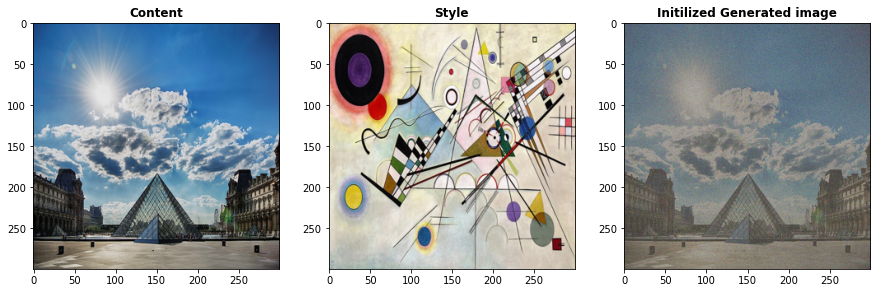

In [7]:
#plot the images.
figure, axarr = plt.subplots(1,3 ,figsize=(15,15))

axarr[0].imshow(model.normalize_and_clip(model.content_image))
axarr[0].set_title("Content", fontweight ="bold")
axarr[1].imshow(model.normalize_and_clip(model.style_image))
axarr[1].set_title("Style", fontweight ="bold")
axarr[2].imshow(model.normalize_and_clip(model.generated_image))
axarr[2].set_title("Initilized Generated image", fontweight ="bold")


**Training The Model**

Itration(1) loss: 241756288.0   content: 3838616  style: 237917680
Itration(2) loss: 202743328.0   content: 4688984  style: 198054336
Itration(3) loss: 147208800.0   content: 5819744  style: 141389056
Itration(4) loss: 107645928.0   content: 7370331  style: 100275600
Itration(5) loss: 93072984.0   content: 8710145  style: 84362840
Itration(6) loss: 81222728.0   content: 9218546  style: 72004184
Itration(7) loss: 70133832.0   content: 9380889  style: 60752944
Itration(8) loss: 61115552.0   content: 9514286  style: 51601268
Itration(9) loss: 54030008.0   content: 9602021  style: 44427988
Itration(10) loss: 49162456.0   content: 9645138  style: 39517320
Itration(11) loss: 45757064.0   content: 9677095  style: 36079968
Itration(12) loss: 43061924.0   content: 9729139  style: 33332786
Itration(13) loss: 40712424.0   content: 9800073  style: 30912352
Itration(14) loss: 38593536.0   content: 9866414  style: 28727122
Itration(15) loss: 36717244.0   content: 9912369  style: 26804876
Itration(16

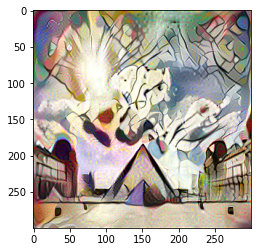

In [8]:
model.train(epochs=300, learning_rate=10.0)
model.show(model.generated_image)


Text(0.5, 1.0, 'Output')

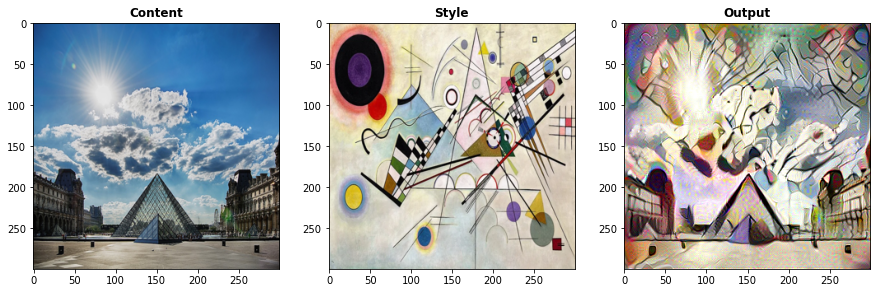

In [9]:
#plot the images.
figure, axarr = plt.subplots(1,3 ,figsize=(15,15))

axarr[0].imshow(model.normalize_and_clip(model.content_image))
axarr[0].set_title("Content" , fontweight ="bold")
axarr[1].imshow(model.normalize_and_clip(model.style_image))
axarr[1].set_title("Style" , fontweight ="bold")
axarr[2].imshow(model.normalize_and_clip(model.generated_image))
axarr[2].set_title("Output" , fontweight ="bold")

In [10]:
#save the generated_image
imageio.imwrite("/content/output.png", model.normalize_and_clip(model.generated_image))    
